In [9]:
import os
import sys
import pyts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

from tsx.perturbation import TimeSeriesPerturbation
from tsx.xai.lime import LIMETimeSeries, XAIModels
from tsx.xai import evaluation as eva

from data_util import *
from viz import *

import itertools
import pandas as pd
from biokit.viz import corrplot

### Objectives
1. Evaluate between different XAI models but same family (Ridge, for example)
1. Evaluate between different DL model, but same XAI model
1. Evaluate the same on Multivariate Time Series
1. (Todo) -> Evaluate the same on Univariate Time Series

### Metrics to Evaluation
1. coef correlations
1. r2-scores
    the scores when building XAI model in approximation process $f(z) ~ g(z') = w * z'$


## Prepare Data Set

In [3]:
independents = ["dew", "temp", "press", "wind_direction", "wind_speed", "snow", "rain"]
dependent = "pollution"

# Load data
df = load_data_set_bejin()
x_scaler, y_scaler = get_xy_scalers(df, independents, dependent)

# Normalize data 
df_norm = df.copy()
df_norm[independents] = x_scaler.transform(df[independents].values)
df_norm[dependent] = y_scaler.transform(df[dependent].values.reshape(-1, 1))

# Global param
n_steps = 128
window_size = 8
n_variables = len(independents)
samples_size = 100

In [4]:
# Prepare predict function
wavenet = tf.keras.models.load_model(f"{DATA_DIR}/wavenet_mts_128_1.h5")
lstm = tf.keras.models.load_model(f"{DATA_DIR}/lstm_mts_128_1.h5")

def predict_fn(z, model=lstm):
    z_reshaped = z.T.reshape(1, 128, 7)
    z_hat = model.predict(z_reshaped)
    # to avoid zero coef_ for z_hat in[0, 1]
    z_hat = y_scaler.inverse_transform(z_hat.reshape(-1, 1))  
    z_hat = z_hat.ravel()   # z_hat will arround 50 - 150
    return z_hat[0]

def lstm_fn(z):
    return predict_fn(z, model=lstm)

def wavenet_fn(z):
    return predict_fn(z, model=wavenet)

In [187]:
# Test set (random)
test_set = []
n_instances = 1000
for i in range(n_instances):
    i_df = get_instance_x(df_norm, n_steps + 1, independents + 
    [dependent])
    _x = i_df.loc[:n_steps-1, independents]
    _y = i_df[dependent]   
    test_set.append((_x.values.T, _y.to_numpy()[-1]))

In [188]:
X, y_true = zip(*test_set)
X_reshaped = np.stack([x.T for x in X])
y_pred = lstm.predict(X_reshaped).ravel()
from sklearn.metrics import r2_score, mean_squared_error

acc_r2 = r2_score(y_true, y_pred)
acc_mse = mean_squared_error(y_true, y_pred)

-1.249737742888732 0.017623514445516537


In [189]:
X, y_true = zip(*test_set)
X_reshaped = np.stack([x.T for x in X])
y_pred = wavenet.predict(X_reshaped).ravel()
from sklearn.metrics import r2_score, mean_squared_error

acc_r2 = r2_score(y_true, y_pred)
acc_mse = mean_squared_error(y_true, y_pred)


-0.5658436931035393 0.012266171482457998


In [190]:
print(y_true[0], y_pred[0])


0.07645875251509054 0.025529142


In [6]:
# Prepare Params for different models
scales = ["async", "sync"]
repl_fn = ["zeros", "local_mean", "global_mean"]
model_fn = ["lstm_fn", "wavenet_fn"]

params = list(itertools.product(scales, repl_fn, model_fn))
params_df = pd.DataFrame([{"scale": s, "method": m, "model":model} for s, m, model in params])
# print(params_df)
params_df.style\
    .apply(lambda s: ['background-color: %s' % ('grey' if v else '') for v in s == "async"]) \
    .apply(lambda s: ['background-color: %s' % ('green' if v else '') for v in s == "sync"]) \
    .applymap(lambda s: 'color: %s' % ('cyan' if s == "lstm_fn" else '' )) \
    .applymap(lambda s: 'color: %s' % ('orange' if s == "wavenet_fn" else '' ))

,scale,method,model
0,async,zeros,lstm_fn
1,async,zeros,wavenet_fn
2,async,local_mean,lstm_fn
3,async,local_mean,wavenet_fn
4,async,global_mean,lstm_fn
5,async,global_mean,wavenet_fn
6,sync,zeros,lstm_fn
7,sync,zeros,wavenet_fn
8,sync,local_mean,lstm_fn
9,sync,local_mean,wavenet_fn


In [159]:
# Multinrun average explains for different xai models (# dl model)

# Todo: add this function to lime.py
#   coef_to_original = m.perturb_obj._x_masked
# x_df = get_instance_x(df_norm, n_steps, independents)
x_arr = X[0]

# Generate Explanations over 10 instances
lime_ts = LIMETimeSeries(
        scale="sync", 
        window_size=window_size,                                
        sample_size=samples_size, 
        perturb_method="zeros"
    )
lime_ts.xai_estimator = XAIModels.Ridge
lime_ts.explain_instances(X[:10], predict_fn=predict_fn)
coef = lime_ts.coef
x_coef = lime_ts.perturb_obj._x_masked(x_arr, coef) 

In [160]:
# Get absolute value for weight
t = np.abs(x_coef)

# Create a mask based on 90 percentile of x_coef
#   > 1 mean on , 0 means off (disabled)
p_90 = np.percentile(t, 90, axis=1, interpolation='higher')
mask = 1 - (t >= p_90.reshape(t.shape[0], -1))

# This is a mask for x based on 90 percentile of x_coef
print(t.shape)
print("90 percentile shape", p_90.shape)
print("mask-shape", mask.shape)


(7, 128)
90 percentile shape (7,)
mask-shape (7, 128)


In [161]:
# Calculate zeros replacements
r_zeros = np.zeros_like(x_arr)

# Calculate means replacements
m = x_arr.mean(axis=1)
r_mean = x_arr**0 * m.reshape(x_arr.shape[0], -1)

print(r_zeros.shape, r_mean.shape)

(7, 128) (7, 128)


In [162]:
# Generate new perturbed sample. (new x)
#   e.g: zeros
x_arr_new = x_arr * mask + r_zeros * (1 - mask)
print(x_arr_new.shape)

(7, 128)


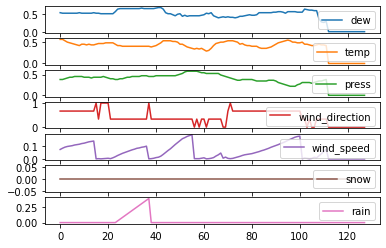

In [163]:
# Plot to see where it is perturbed
_ = pd.DataFrame(x_arr_new.T, columns=x_df.columns).plot(subplots=1)

In [ ]:
# Repeat to get new test set
#   - T = test_set (original)
#   - T_r = test_set_random
#   - T_p = test_set_perturbed
#   - targets (no change)

# Fit and calculate accuracy